# Predict Stock price

This is a notebook illustrating how to predict stock price from [Yahoo Finance](https://finance.yahoo.com/) data with a recurrent neural network.

In [1]:
# Install library for fetching Yahoo Finance data
!pip install yfinance

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from typing import Dict, List, Tuple, Union
from numpy import array, arange, zeros
from numpy.random import permutation, randint, uniform
from pathlib import Path
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = [12, 9]  # plot larger than default

Define some constants (adapt the values to your use case):

In [3]:
stock = 'AAPL'
# Train model with daily data between `start` and `end`
start = (datetime.now() - timedelta(days=3*365+1)).strftime("%Y-%m-%d")
end = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
target = 'Adj Close'
# We will use the `n_prior` previous days to predict the nex `n_to_predict` days
n_prior = 30
n_to_predict = 7
# Proportion of validation and test data
p_val = .1
p_test = .2 

## Fetching data
Fetch data directly from the *yfinance* library

In [4]:
data = yf.download(tickers=stock, period='1d', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-14,47.887501,47.892502,47.555000,47.700001,46.119915,86440400
2018-06-15,47.507500,47.540001,47.064999,47.209999,45.646137,246876800
2018-06-18,46.970001,47.305000,46.799999,47.185001,45.621964,73939600
2018-06-19,46.285000,46.582500,45.862499,46.422501,44.884731,134314000
2018-06-20,46.587502,46.799999,46.432499,46.625000,45.080524,82514800
...,...,...,...,...,...,...
2021-06-07,126.169998,126.320000,124.830002,125.900002,125.900002,71057600
2021-06-08,126.599998,128.460007,126.209999,126.739998,126.739998,74403800
2021-06-09,127.209999,127.750000,126.519997,127.129997,127.129997,56877900


We want only the `target` values:

In [6]:
data = data[[target]]

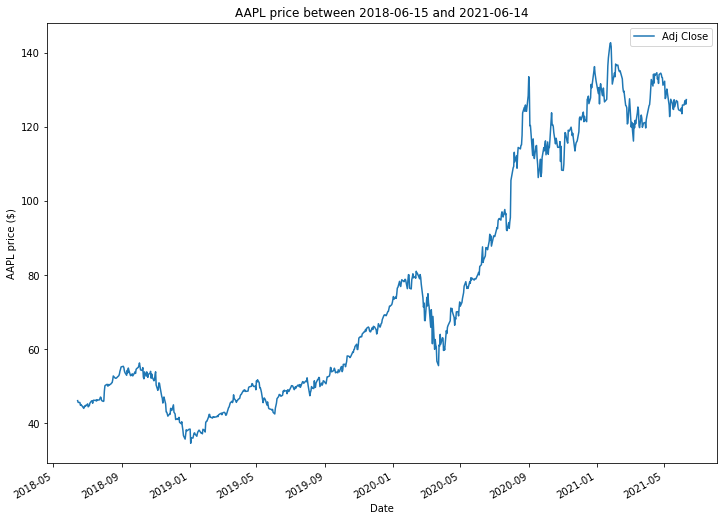

In [7]:
data.plot()
plt.xlabel(f'Date')
plt.ylabel(f'{stock} price ($)')
plt.title(f'{stock} price between {start} and {end}')
plt.show()

## Prepare training data
First we define a function `build_x_y()` that will take slices from the column `target` of `data`. Each slice will be split into a range of `n_prior` days for `X` and the following `n_to_predict` day for `y`.

### Create `X` and `y`

In [8]:
def build_x_y(data: DataFrame, target: str = 'Close',  n_prior: int = 21, 
              n_to_predict: int = 14) -> Tuple[array, array]:
    """ Split `df` into X and y. X is a 2-dimensional numpy array. The first 
    dimension corresponds to the sample, the second to the sequence in a sample 
    and the third to the features in each element of the sequence. `y` is a 
    2-dimensional array, the first is for the samples and the second for the 
    output values of the corresponding sequence.

    Args:
        data (DataFrame): Preprocessed input dataset
        target (str, optional): Column name of the target variable in `data`. 
            Defaults to 'Close'.
        n_prior (int, optional): Number of days in the past used in each sample
           of the training dataset. Defaults to 21.
        n_to_predict (int, optional): Numbers of day to predict ahead. 
            Defaults to 14.

    Returns:
        Tuple[array, array]: Input and output corresponding to the preprocessed 
          samples in `data`.
    """
    n = n_prior + n_to_predict  # batch "width"
    s0, s1 = data.shape[0], data.shape[1]
    s = s0 - n  # size of training data

    X, y = zeros(shape=(s, n_prior, s1)), zeros(shape=(s, n_to_predict))
    shuffled_order = permutation(arange(0, s, 1)) # shuffle data directly
    for i in shuffled_order:
        X[i] = data.iloc[i: i + n_prior,:].values
        y[i] = data[target][i + n_prior: i + n]
        # Normalize each batch individually
        min_value, max_value = X[i].min(), X[i].max()
        X[i] = (X[i] - min_value) / (max_value - min_value) 
        y[i] = (y[i] - min_value) / (max_value - min_value)
        
    return X, y

In [9]:
X, y = build_x_y(data=data, target='Adj Close', n_prior=n_prior, n_to_predict=n_to_predict)

### Split `X` and `y`
Compute where to split `X` and `y` to obtain a proportion `p_val` of validation data and `p_test` of test data:

In [10]:
def get_split_inds(size: int, p_val: float = .1, p_test: float = .2, 
                   do_shuffle: bool = False) -> Tuple[array, array, array]:
    """ Compute indices corresponding to the random splitting of `size` samples in train, validation and test sets 
    with size corresponding to `p_test` and `p_val`.

    Args:
        size (int): Number of samples in the dataset to split.
        p_val (float, optional): Proportion of validation data in the split. Defaults to .1.
        p_test (float, optional): Proportion of test data in the split. Defaults to .2.

    Returns:
        Tuple[array, array, array]: Three arrays corresponding to the indices of the train, validation and test sets.
    """
    indices = arange(0, size, 1)
    if do_shuffle:
      indices = permutation(indices)

    val_split_ind = round(size * (1 - p_test - p_val))
    test_split_ind = round(size * (1 - p_test))

    train_inds = indices[:val_split_ind]
    val_inds = indices[val_split_ind: test_split_ind]
    test_inds = indices[test_split_ind:]
    
    return train_inds, val_inds, test_inds

In [11]:
size = X.shape[0]
train_inds, val_inds, test_inds = get_split_inds(size=size, p_val=p_val, p_test=p_test)
X_train, X_val, X_test = X[train_inds], X[val_inds], X[test_inds]
y_train, y_val, y_test = y[train_inds], y[val_inds], y[test_inds]

## Modelization



In [12]:
from tensorflow.keras.layers import Input, GRU, Lambda, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsolutePercentageError,MeanSquaredError
from tensorflow import expand_dims, matmul
from tensorflow.nn import softmax

Define some model trainin specific constants:

In [13]:
from os import getcwd
n_recurrent_units = 100  # size of the recurrent layers
n_dense_units = 64  # size of the final dense layer
scale = .05  # scale for attention layer
lr = 1e-2  # learning rate
dr = .9  # decay rate
max_epochs = 300
patience = 10
batch_size = 32
model_path = getcwd()+'/models'  # if None: will not be persisted

Define a function to provide a deep recurrent model:

In [14]:
def attention_seq(query_value, scale):
    """ Define time series specific attention layer
    see: https://stackoverflow.com/questions/61757475/sequence-to-sequence-for-time-series-prediction """
    query, value = query_value
    score = matmul(query, value, transpose_b=True) # (batch, timestamp, 1)
    score = scale * score # scale with a fixed number (it can be finetuned or learned during train)
    score = softmax(score, axis=1) # softmax on timestamp axis
    score = score * query # (batch, timestamp, feat)
    return score


def get_model(n_prior: int, n_features: int, n_to_predict: int, scale: float = .05,
              n_recurrent_units: int = 100, n_dense_units=62) -> Model:
    """ Build and return a recurrent auto-encoder model for predicting.

    Args:
        n_prior (int): number of days in the past used in each sample of the training dataset.
        n_features (int): number of  (columns) in the input dataset.
        n_to_predict (int): numbers of day to predict ahead
        n_units (int): size of the recurrent layer

    Returns:
        tf.keras.models.Model: reccurent auto-encoder model for predicting
    """
    inp = Input((n_prior, n_features))
    seq, state = GRU(n_recurrent_units, activation='relu',
                    return_state=True, return_sequences=True)(inp)
    att = Lambda(attention_seq, arguments={'scale': scale})([seq, expand_dims(state, 1)])
    x = GRU(n_recurrent_units, activation='relu')(att)
    
    x = Dense(n_dense_units, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(n_to_predict)(x)

    model = Model(inp, out)
    return model

Define a function for training the model:

In [15]:
def train_persist_model(model: Model, X_train: DataFrame, X_val: DataFrame, X_test: DataFrame, y_train: Series,
                        y_val: Series, y_test: Series, model_name: str, model_path: Union[str, Path, None], lr: float = 1e-3, dr: float = .99, 
                        max_epochs: int = 300, patience: int = 10, batch_size: int = 32, plot: bool = True, verbose: int = 0) -> None:
    """ Train and persist a model for predicting.

    Args:
        model (tf.keras.models.Model): Tensorflow Keras model to train and persist
        X_train (DataFrame): Training input dataset corresponding to past data with their features
        X_val (DataFrame): Validation input dataset. Used at each batch to monitor model performance.
        X_test (DataFrame): Test input dataset, for measuring model performance after training.
        y_train (Series): Training output ground truth
        y_val (Series): Validation output ground truth
        y_test (Series): Test output ground truth.
        model_name (str): name of the model
        model_path (Union[str, Path]): Path under which the model will be persisted. If None, the model will not be persisted.
        lr (float, optional): Learning rate for the optimizer training the model. Defaults to 1e-3.
        dr (float, optional): Decay rate for the learning rate. Defaults to .99.
        max_epochs (int, optional): Max. number of epochs for training the model. Defaults to 300.
        patience (int, optional): number of epochs without improvement of val_loss before stopping
        batch_size (int, optional): Number of training data samples in each batch. Defaults to 32.
        plot (bool, optional): If to generate and persist plot corresponding to the training history. Defaults to True.
        verbose (int, optional): If to print details during the training. Defaults to 0.
    """
    reduce_lr = LearningRateScheduler(lambda x: lr * dr ** x)
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min',
                                   restore_best_weights=True)


    model.compile(optimizer=Adam(),
                loss='mse')#,
                #metrics=[MeanAbsolutePercentageError()])

    history = model.fit(X_train, y_train, 
                        epochs=max_epochs, 
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        verbose=verbose,
                        callbacks=[reduce_lr, early_stopping])

    if plot:
        plot_training(history=history, model_name=model_name)
    
    if model_path:
      model.save(model_path)
      print(f'INFO: model {model_path} saved under {model_path}')

    results = model.evaluate(X_test, y_test)
    test_loss=results#, test_mape = results[0], results[1]
    print(f'INFO: model evaluation on test data:\n\tMSE: {test_loss}')#'\n\tMAPE: {test_mape}')
    return test_loss

And finally, define a function to plot the model training:

In [16]:
def plot_training(history: History, model_name: str) -> None:
    """ Plot history of model training. The model must contain MAE as a metric.
        Saves the plot in the folder `plots_dir` defined in *parameters.py* under the name `model_name`.jpg
    Args:
        history (tf.keras.callbacks.History): model history resulting from `.fit()`
        model_name (str): [description]
    """
    fig, (ax2) = plt.subplots()
    fig.suptitle(f'{model_name} training')
    
    #ax1.plot(history.history['mean_absolute_percentage_error'])
    #ax1.plot(history.history['val_mean_absolute_percentage_error'])
    #ax1.set_title(f'{model_name} mean_absolute_percentage_error')
    #ax1.set(xlabel='epoch', ylabel='mean_absolute_error')
    #ax1.legend(['train', 'val'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} MSE')
    ax2.set(xlabel='epoch', ylabel='MSE')
    ax2.legend(['train', 'val'], loc='upper left')
    
    plt.show()

Now combine all this to train the model:

In [17]:
model = get_model(n_prior=n_prior, n_features=1, n_to_predict=n_to_predict, scale=scale, n_recurrent_units=n_recurrent_units, n_dense_units=n_dense_units)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 30, 100), (N 30900       input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 100)       0           gru[0][1]                        
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 30, 100)      0           gru[0][0]                        
                                                                 tf.expand_dims[0][0]         

Epoch 1/300
16/16 [==============================] - 4s 103ms/step - loss: 0.5448 - val_loss: 0.2121
Epoch 2/300
16/16 [==============================] - 1s 58ms/step - loss: 0.1978 - val_loss: 0.1774
Epoch 3/300
16/16 [==============================] - 1s 60ms/step - loss: 0.1329 - val_loss: 0.1721
Epoch 4/300
16/16 [==============================] - 1s 58ms/step - loss: 0.1101 - val_loss: 0.1418
Epoch 5/300
16/16 [==============================] - 1s 59ms/step - loss: 0.1002 - val_loss: 0.1371
Epoch 6/300
16/16 [==============================] - 1s 62ms/step - loss: 0.0916 - val_loss: 0.1372
Epoch 7/300
16/16 [==============================] - 1s 59ms/step - loss: 0.0854 - val_loss: 0.1387
Epoch 8/300
16/16 [==============================] - 1s 62ms/step - loss: 0.0933 - val_loss: 0.1353
Epoch 9/300
16/16 [==============================] - 1s 61ms/step - loss: 0.0896 - val_loss: 0.1337
Epoch 10/300
16/16 [==============================] - 1s 61ms/step - loss: 0.0903 - val_loss: 0.137

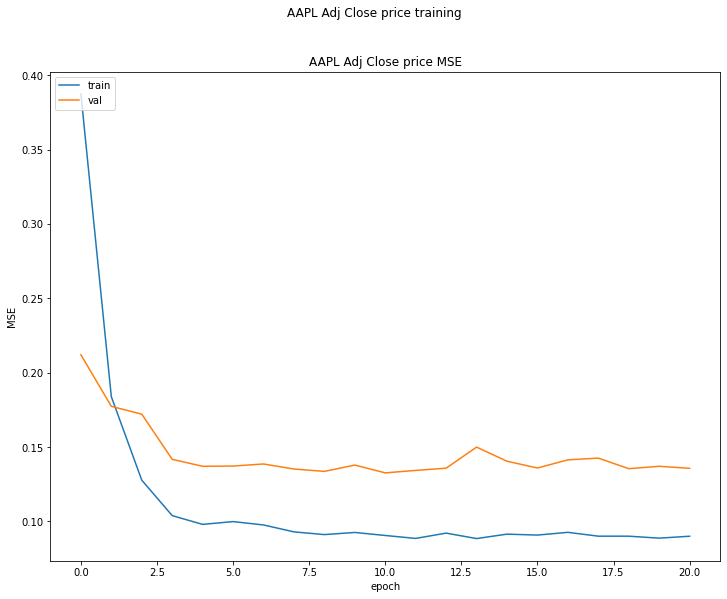

INFO:tensorflow:Assets written to: /home/fawn/code/PhilEkev/US_markets/notebooks/models/assets
INFO: model /home/fawn/code/PhilEkev/US_markets/notebooks/models saved under /home/fawn/code/PhilEkev/US_markets/notebooks/models
5/5 [==============================] - 0s 15ms/step - loss: 0.0812
INFO: model evaluation on test data:
	MSE: 0.08121944963932037


0.08121944963932037

In [18]:
train_persist_model(model=model, X_train=X_train, X_val=X_val, X_test=X_test, 
                    y_train=y_train, y_val=y_val, y_test=y_test, 
                    model_name=f'{stock} {target} price', model_path=model_path, lr=lr, dr=dr,
                    max_epochs=max_epochs, patience=patience, 
                    batch_size=batch_size, plot=True, verbose=1)

## Grid search optimal model and training hyperparameters

In [19]:
def evaluate_hp(hp: Dict):
  model = get_model(n_prior=n_prior, n_features=1, n_to_predict=n_to_predict,
              scale = hp.get('scale'),
              n_recurrent_units=hp.get('n_recurrent_units'), 
              n_dense_units=hp.get('n_dense_units'))
  error = train_persist_model(model=model, X_train=X_train, X_val=X_val, X_test=X_test, 
                    y_train=y_train, y_val=y_val, y_test=y_test, 
                    model_name=f'{stock} {target} price', model_path=None, 
                    lr=hp.get('lr'), dr=hp.get('dr'),
                    max_epochs=max_epochs, patience=patience, 
                    batch_size=batch_size, plot=False, verbose=0)
  return error
  

def random_grid_search(n_trials: int = 100, 
                        n_recurrent_units_min: int = 10, 
                        n_recurrent_units_max: int = 100, 
                        n_dense_units_min: int = 20, 
                        n_dense_units_max: int = 100,
                        scale_min: float = .01, scale_max: float = .1,
                        lr_min: float = 1e-4, lr_max: float = 1e-1, 
                        dr_min: float = 0.8, dr_max: float = 0.999):
  mapping = {'n_recurrent_units': [n_recurrent_units_min, n_recurrent_units_max, 'int'], 
              'n_dense_units': [n_dense_units_min, n_dense_units_max, 'int'],
              'scale': [scale_min, scale_max, 'float'],
              'lr': [lr_min, lr_max, 'float'], 
              'dr': [dr_min, dr_max, 'float']}
  res = []
  for _ in range(n_trials):
    hp = dict()
    for name, parameters in mapping.items():
      if parameters[2] == 'int':
        value = int(randint(low=parameters[0], high=parameters[1]))
      else:
        value = uniform(low=parameters[0], high=parameters[1])
      hp[name] = value
    print(f'INFO: trying {hp}...')
    error = evaluate_hp(hp)
    print(f'INFO: MSE: {error}')
    res.append({'hp': hp, 'MSE': error})
  return res
  

Define parameters for random grid search:

In [20]:
n_trials = 30
n_recurrent_units_min = 10, 
n_recurrent_units_max = 100, 
n_dense_units_min = 20
n_dense_units_max = 100
scale_min = .01
scale_max = .1
lr_min = 1e-4
lr_max = 1e-1
dr_min = 0.8
dr_max = 0.999

In [21]:
rgs_result = random_grid_search(n_trials=n_trials, 
                        n_recurrent_units_min=n_recurrent_units_min, 
                        n_recurrent_units_max=n_recurrent_units_max, 
                                
                        n_dense_units_min=n_dense_units_min, 
                        n_dense_units_max=n_dense_units_max,
                        scale_min=scale_min, scale_max=scale_max,
                        lr_min=lr_min, lr_max=lr_max, 
                        dr_min=dr_min, dr_max=dr_max)

INFO: trying {'n_recurrent_units': 48, 'n_dense_units': 63, 'scale': 0.04900397273010799, 'lr': 0.03794242717210954, 'dr': 0.8556702934007279}...
5/5 [==============================] - 0s 12ms/step - loss: 0.0842
INFO: model evaluation on test data:
	MSE: 0.08416172116994858
INFO: MSE: 0.08416172116994858
INFO: trying {'n_recurrent_units': 38, 'n_dense_units': 20, 'scale': 0.0843704914507915, 'lr': 0.07921980689401503, 'dr': 0.8605897702140868}...
5/5 [==============================] - 0s 12ms/step - loss: 0.1754
INFO: model evaluation on test data:
	MSE: 0.17538140714168549
INFO: MSE: 0.17538140714168549
INFO: trying {'n_recurrent_units': 97, 'n_dense_units': 93, 'scale': 0.024962775711912723, 'lr': 0.026523081960861717, 'dr': 0.801059854596387}...
5/5 [==============================] - 0s 16ms/step - loss: 0.0804
INFO: model evaluation on test data:
	MSE: 0.0803576335310936
INFO: MSE: 0.0803576335310936
INFO: trying {'n_recurrent_units': 79, 'n_dense_units': 37, 'scale': 0.0486617475

INFO: model evaluation on test data:
	MSE: 0.4048348665237427
INFO: MSE: 0.4048348665237427
INFO: trying {'n_recurrent_units': 69, 'n_dense_units': 61, 'scale': 0.047557532693788256, 'lr': 0.002952250443186258, 'dr': 0.8112571350237694}...
5/5 [==============================] - 0s 15ms/step - loss: 0.1098
INFO: model evaluation on test data:
	MSE: 0.10982030630111694
INFO: MSE: 0.10982030630111694
INFO: trying {'n_recurrent_units': 14, 'n_dense_units': 51, 'scale': 0.055408531885350186, 'lr': 0.008509424243672051, 'dr': 0.826615935552262}...
5/5 [==============================] - 0s 12ms/step - loss: 0.1140
INFO: model evaluation on test data:
	MSE: 0.11399400979280472
INFO: MSE: 0.11399400979280472
INFO: trying {'n_recurrent_units': 61, 'n_dense_units': 27, 'scale': 0.07242474971068863, 'lr': 0.047078537178476036, 'dr': 0.8894802852888192}...
5/5 [==============================] - 0s 13ms/step - loss: 0.0870
INFO: model evaluation on test data:
	MSE: 0.08699978142976761
INFO: MSE: 0.0

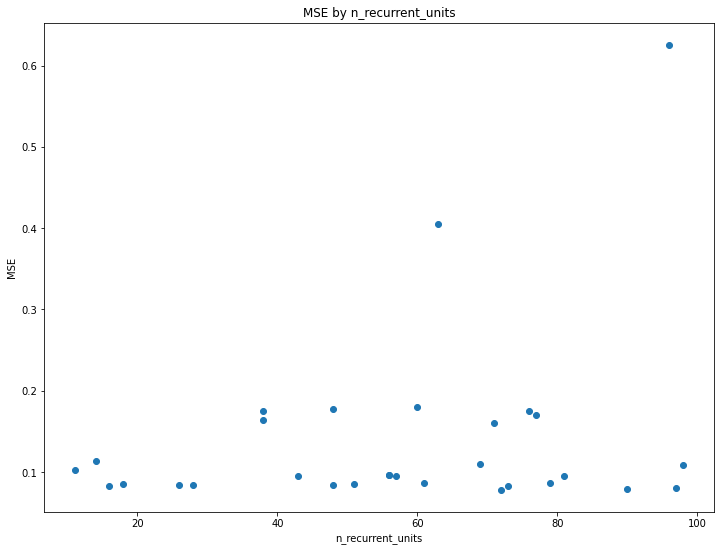

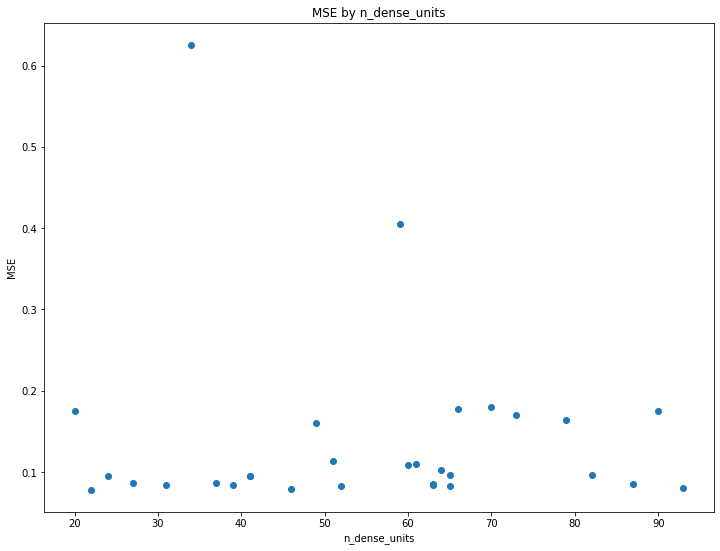

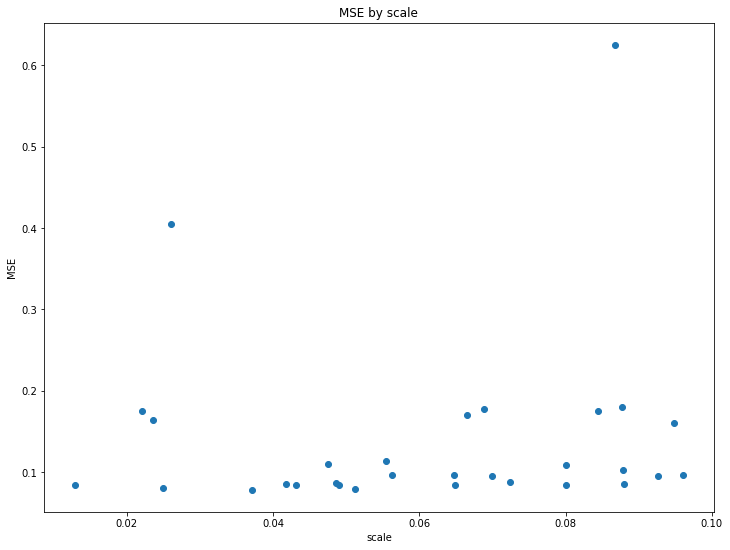

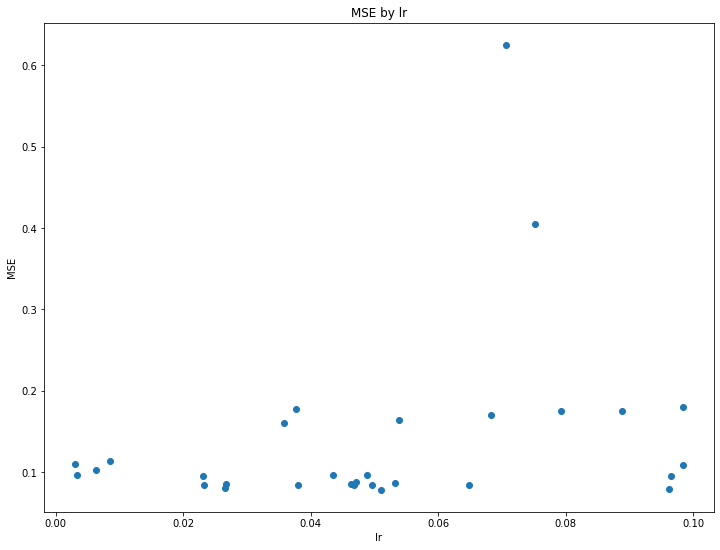

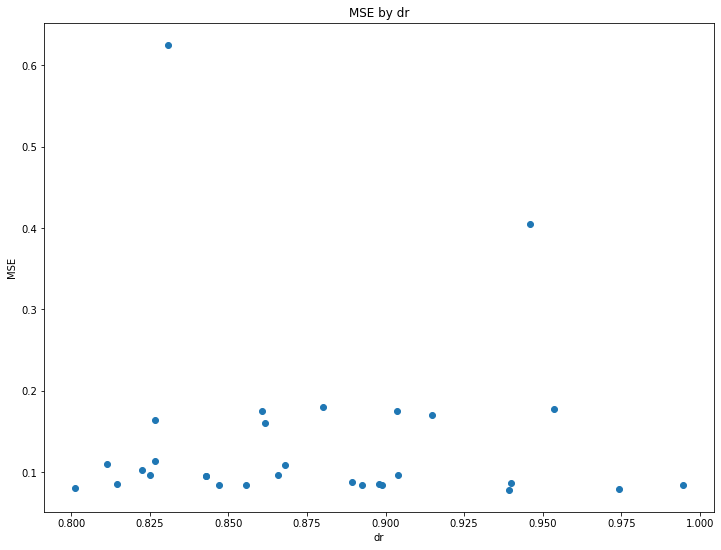

In [22]:
hyperparameters = list(rgs_result[0].get('hp').keys())
ys = [d.get('MSE') for d in rgs_result]
for hyperparameter in hyperparameters:
  xs = [d.get('hp').get(hyperparameter) for d in rgs_result]
  plt.scatter(xs, ys)
  plt.xlabel(hyperparameter)
  plt.ylabel('MSE')
  plt.title(f'MSE by {hyperparameter}')
  plt.show()

In [23]:
def get_best_hp(rgs_result: List[Dict]):
  best_error = None
  for r in rgs_result:
    if r.get('MSE') is None:
      continue
    if best_error is None or r.get('MSE') < best_error:
      best_hp = r.get('hp')
      best_error = r.get('MSE')
  return best_hp, best_error

In [24]:
best_hp, best_error = get_best_hp(rgs_result)
print(f'best_hp: {best_hp}\nCorresponding best_MSE: {best_error}')

best_hp: {'n_recurrent_units': 72, 'n_dense_units': 22, 'scale': 0.03715902342372474, 'lr': 0.0510617926860471, 'dr': 0.9393668667473813}
Corresponding best_error: 0.07828111201524734


In [25]:
model = get_model(n_prior=n_prior, n_features=1, n_to_predict=n_to_predict,
              scale = best_hp.get('scale'),
              n_recurrent_units=best_hp.get('n_recurrent_units'), 
              n_dense_units=best_hp.get('n_dense_units'))

train_persist_model(model=model, X_train=X_train, X_val=X_val, X_test=X_test, 
                  y_train=y_train, y_val=y_val, y_test=y_test, 
                  model_name=f'{stock} {target} price', model_path=None, 
                  lr=best_hp.get('lr'), dr=best_hp.get('dr'),
                  max_epochs=max_epochs, patience=patience, 
                  batch_size=batch_size, plot=False, verbose=0)

5/5 [==============================] - 0s 15ms/step - loss: 0.0807
INFO: model evaluation on test data:
	MSE: 0.0807061642408371


0.0807061642408371

## Make prediction

In [26]:
def generate_prediction(predict_from: str, stock: str, target: str, model: Model, 
                        n_prior: int = 21, valid: bool = False) -> None:
  """ Generate predictions from the date `predict_from` based on the `n_prior` 
  previous values for the price `target` of `stock`
    Args:
        predict_from (str): format 'yyyy-mm-dd', date after which the predictions will start
        stock (str): code of the stock on Yahoo Finance
        target (str): target price to predict (e.g. 'Close')
        model (Model): Tensorflow model trained for making predictions
        n_prior (int): number of previous values to use for the prediction 
            (must be the same than the one used to train the `model`)
        valid (bool): if to plot the actual vs. the predicted values 
            (only if the prediction time range lies in the past)
    """
  predict_from_dt = datetime.strptime(predict_from, '%Y-%m-%d')
  start_dt = predict_from_dt - timedelta(days=int(n_prior * 1.5))
  start = start_dt.strftime('%Y-%m-%d')
  data = yf.download(tickers=stock, period='1d', start=start, end=predict_from)
  data = data[target]
  # Normalize
  min_value, max_value = data.min(), data.max()
  data = (data - min_value) / (max_value - min_value)
  data = data.values[data.shape[0] - n_prior:].reshape(1, -1, 1)

  predictions = model.predict(data)
  predictions = predictions * (max_value - min_value) + min_value # de-normalize
  predictions = predictions.flatten()
  prediction_dates = [predict_from_dt + timedelta(days=i+1) for i in range(predictions.shape[0])]
  predictions = DataFrame({'date': prediction_dates, 'prediction': predictions})
  predictions = predictions.set_index('date')
  if valid:
    start_valid = predict_from_dt + timedelta(days=1)
    end_valid = predict_from_dt + timedelta(int(1.5 * predictions.shape[0]))
    start_valid = start_valid.strftime('%Y-%m-%d')
    end_valid = end_valid.strftime('%Y-%m-%d')
    true_values = yf.download(tickers=stock, period='1d', start=start_valid, end=end_valid)
    true_values = true_values[[target]].loc[:predictions.index.max(),:]
    fig, ax = plt.subplots(1)
    ax.plot(true_values, label='actual')
    ax.plot(predictions, label='predicted')
    ax.set_title(f'Actual vs. Prediction for stock {stock} between {start_valid} and {end_valid}')
    ax.set(xlabel='day', ylabel=f'{stock} ${target} price ($)')
    ax.legend()
    plt.show()
  return predictions

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: Data doesn't exist for startDate = 1623967200, endDate = 1624744800


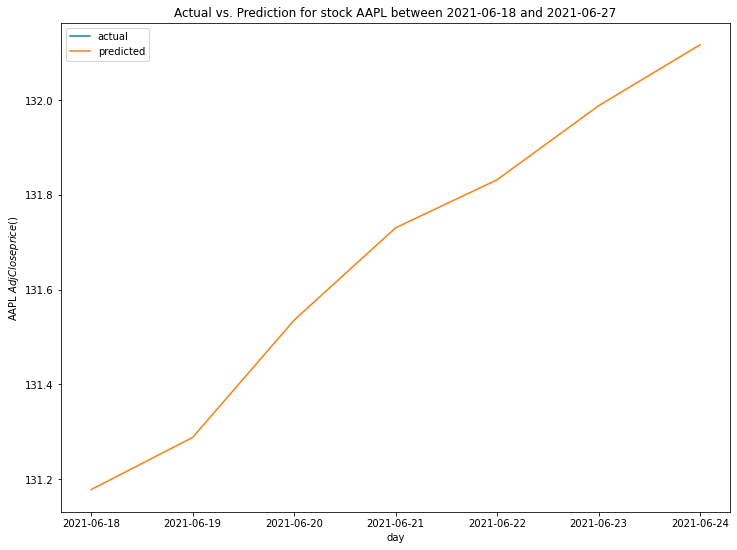

In [27]:
predict_from = '2021-6-17'
predictions = generate_prediction(predict_from=predict_from, stock=stock, 
                                  target=target, model=model, n_prior=n_prior, 
                                  valid=True)

In [28]:
predictions

,prediction
date,
2021-06-18,131.178207
2021-06-19,131.288315
2021-06-20,131.535583
2021-06-21,131.730377
2021-06-22,131.831619
2021-06-23,131.987656
2021-06-24,132.116379
